In [8]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import h5py
import yaml
import scipy.interpolate as interpolate
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['font.size'] = 18

In [6]:
filename = "EBL_fit_MC_MBPWL_nit5_20220429094330.hdf5"

load = h5py.File(filename,"r")
chisqs_iter = np.array(load['chisqs'])
alphas_iter = np.array(load['alhpas'])

with open("EBL_fit_config.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
niter = inp_config["niter"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

if fit_func_name == "MBPWL":
        knots = inp_config["knots"]
        Efirst = inp_config["Efirst"]
        Elast = inp_config["Elast"]

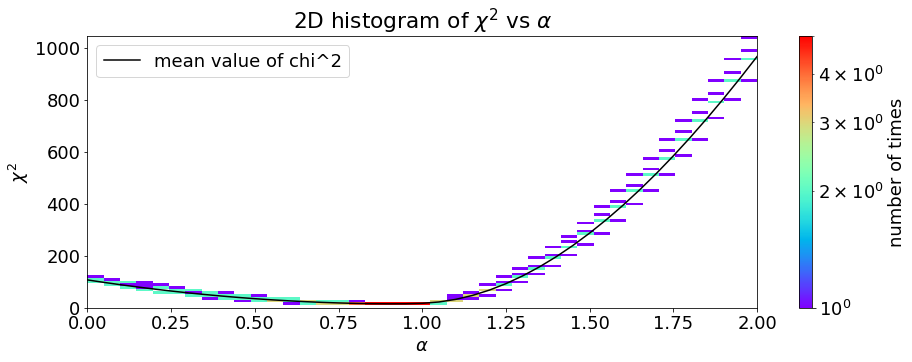

A 20.0 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 100.0 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 100.0 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
The median minimum is at alpha =  0.9  +  0.06  -  0.06
Energy migration =  True


In [9]:
chisqs_iter = np.array(chisqs_iter)
alphas_iter = np.array(alphas_iter)
alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])
alphas = alphas_iter[0]


fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of chi^2")
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),100], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of chi^2 values")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
ax.legend()
ax.set_ylim(bottom = 0)
# ax.set_xlim(0.5,1.15)
fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"2D histogram of $\chi^2$ vs $\alpha$")
plt.show()

sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
for i in range(len(alphas_iter)):
    sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
    sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
    sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    number = np.where(np.round(alphas, decimals = 4) == 1)
    if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if number in sigma_2_0[0]:
        s2 += 1
    if number in sigma_3_0[0]:
        s3 += 1
# print(sigma_1)
# print(sigma_2)
# print(sigma_3)
print("A {sig} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / niter * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / niter * 100, decimals = 3)))
print("A {sig} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / niter * 100, decimals = 3)))
# print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

order = np.argsort(alphas_iter[0])
interpx = np.arange(first_bin, last_bin, step/5)
alphas_reord = np.take_along_axis(np.median(alphas_iter, 0), order, axis=0)
chisqs_repord = np.take_along_axis(np.median(chisqs_iter, 0), order, axis=0)
f1 = interpolate.interp1d(alphas_reord, chisqs_repord, kind='linear')
chis_new = f1(interpx)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound_1s = step/5 * np.max(sigma_inter_1s) + first_bin
lower_bound_1s = step/5 * np.min(sigma_inter_1s) + first_bin
# print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
print("The median minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 3), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
print("Energy migration = ", Energy_migration)

